In [1]:
%run eigenfunction_estimator_decomp_class.ipynb
%run data_generator_class.ipynb
%run polynomial_generator_pos.ipynb
%run Tx_class.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.integrate as integrate
import pickle

class observer:
    def __init__(self, f, fobs, hobs, Tx, dTx, mode='static'):
        self.f = f # \dot{x} = f(x)
        self.fobs = fobs # \dot{z} = fobs(z, y=h(x))
        self.hobs = hobs # \hat{x} = hobs(z)
        self.Tx = Tx
        self.dTx = dTx # dz/d\hat{x} = dT(\hat{x})
        self.mode = mode # if mode is static, simulate x and z, if dynamic, simulate x, z, and xhat together

    def simulate(self, initial, t_array):
        # self.initial: initial states
        # self.t: time array
        # self.dim: number of variables in brusselator system
        x0, xhat0 = initial
        z0 = self.Tx(xhat0)
        self.t = t_array
        self.dim = len(x0)
        
        if self.mode == 'static':
            self.model = lambda states, t: np.concatenate((self.f(states[:self.dim]),
                                                        self.fobs(states[self.dim:], states[:self.dim])))
            self.sol = integrate.odeint(self.model, np.concatenate((x0, z0)), self.t)
            self.state_sol, self.obs_sol = self.sol[:, :self.dim], self.sol[:, self.dim:]
            self.xhat_sol = []
            for k in range(self.obs_sol.shape[0]):
                z_scaled = self.obs_sol[k]
                xh = self.hobs(z_scaled)
                self.xhat_sol.append(xh)
            self.xhat_sol = np.array(self.xhat_sol)
        else: 
            self.model = lambda states, t: np.concatenate((self.f(states[:self.dim]), 
                                                           self.fobs(states[self.dim:self.dim*2], states[:self.dim]), 
                                                           np.linalg.solve(self.dTx(states[self.dim*2:]) + np.eye(self.dim)*1e-3, self.fobs(states[self.dim:self.dim*2], states[:self.dim])) 
                                                           ))
            self.sol = integrate.odeint(self.model, np.concatenate((x0, z0, xhat0)), self.t)
            self.state_sol, self.obs_sol, self.xhat_sol = self.sol[:, :self.dim], self.sol[:, self.dim:self.dim*2], self.sol[:, self.dim*2:]
        return self.sol
    
    def make_xt_plot(self):
        plt.figure(figsize=(12, 6))
        for k in range(self.dim):
            plt.subplot(1, self.dim+1, k+1)
            plt.plot(self.t, self.state_sol[:, k], 'k', label=r'$x_{%i}$'%(k+1))
            plt.plot(self.t, self.xhat_sol[:, k], 'b', label=r'$\hat{x}_{%i}$'%(k+1))
            plt.xlabel(r'$t$'), plt.legend()
            
        plt.subplot(1, self.dim+1, self.dim+1)
        plt.plot(self.t, self.obs_sol[:, 0], label=r'$z_1$')
        plt.plot(self.t, self.obs_sol[:, 1], label=r'$z_2$')
        plt.xlabel(r'$t$'), plt.legend()
        plt.tight_layout(), plt.show()
        
    def error(self, T):
        self.error_array = np.sum((self.state_sol - self.xhat_sol)**2, axis=1)[:T]
        self.error_value = integrate.simpson(self.error_array, self.t[:T])

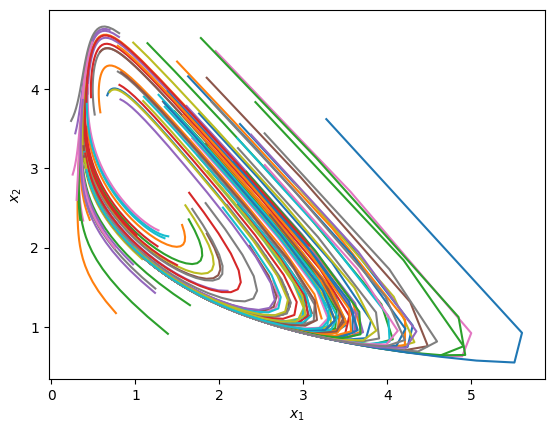

Eigenfunction for m = 1, error = 0.002497
Eigenfunction for m = 2, error = 0.004102
Eigenfunction for m = 3, error = 0.005820
Eigenfunction for m = 4, error = 0.008211
Eigenfunction for m = 5, error = 0.010144
Eigenfunction for m = 6, error = 0.009369
Eigenfunction for m = 7, error = 0.008142
Eigenfunction for n = -7, error = 0.028809
Eigenfunction for n = -6, error = 0.024365
Eigenfunction for n = -5, error = 0.020103
Eigenfunction for n = -4, error = 0.015360
Eigenfunction for n = -3, error = 0.010022
Eigenfunction for n = -2, error = 0.005683
Eigenfunction for n = -1, error = 0.001879
RMSE of Least Squares for T1(x):  0.02408545572785367
RMSE of Least Squares for T2(x):  0.030782367297459274


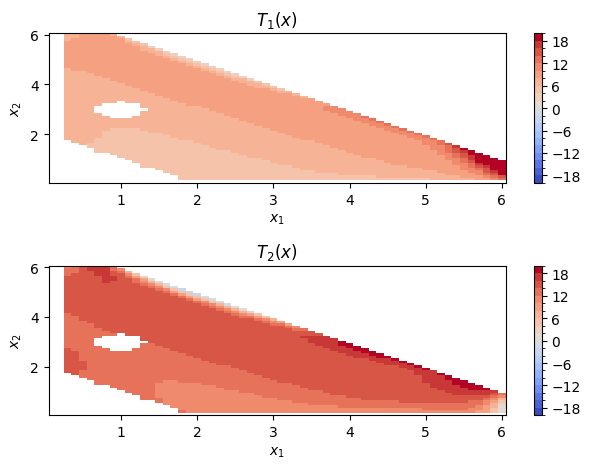

In [3]:
# T(X) 

import pickle

# 1A. PARAMETERS FOR DYNAMICAL SYSTEM
A = 1.0
B = 3.0
deltat = 0.1

# 1B. GENERATE DRIFT SYSTEM DATA
gov_eq_brusselator = lambda x: np.array([A + x[0]**2*x[1] - B*x[0] - x[0], B*x[0] - x[0]**2*x[1]])
brusselator = DynamicalSystem(gov_eq = gov_eq_brusselator, dim=2)

brusselator_trajectories_r = brusselator.sampling(n_datasets = 100, stdev = 0.75, seed_value = 1, fixed_point = [A, B/A], dt = deltat, duration = 3.0, plotting = True)
with open('brusselator_trajectory.dat', 'wb') as f:
    pickle.dump(brusselator_trajectories_r, f)
brusselator_array_real = [brusselator_trajectories_r[key] for key in brusselator_trajectories_r]

brusselator_trajectories_i = brusselator.sampling(n_datasets = 100, stdev = 0.75, seed_value = 1, fixed_point = [A, B/A], dt = deltat, duration = 3.0)
with open('brusselator_trajectory.dat', 'wb') as f:
    pickle.dump(brusselator_trajectories_i, f)
brusselator_array_imag = [brusselator_trajectories_i[key] for key in brusselator_trajectories_i]

brusselator_hx_trajectories = brusselator.sampling(n_datasets = 1000, stdev = 0.75, seed_value = 1, fixed_point = [A, B/A], dt = deltat, duration = 0.1, plotting = False)
brusselator_array_hx = np.vstack(list(brusselator_hx_trajectories.values()))
data_real, data_imag, data_hx = brusselator_array_real, brusselator_array_imag, brusselator_array_hx

# 2A. T(X) PARAMETERS
tau, period = 1.0, 7.16
real_eig, im_eig = -1.0/tau, (2*np.pi/period)*(0.0+1.0j)
fixed_point = np.array([A, B/A])
M, N = 7, 7
lambda_values = np.array([-1.0/(2.0*tau), -1.0/(4.0*tau)])
order = 5
basis_functions = generate_polynomials_centered_and_pos(var=brusselator.dim, order=order, fixed_point=fixed_point) # no additional basis func

# 2B. T(X) ESTIMATE
brusselator_Tx = Tx_estimator(basis_functions = basis_functions, data_real = data_real, data_imag = data_imag, data_hx = data_hx, deltat = deltat, real_eig = real_eig, im_eig = im_eig, N = N, M = M, lambda_values = lambda_values)
brusselator_Tx.Tx_estimate()
brusselator_Tx.plot()
Tx = lambda x: brusselator_Tx.Tx(x).real

In [4]:
# KERNEL RIDGE REGRESSION

# 1A. DATA GENERATION
sigma = 1.15 # standard deviation of sampled data
seed_value = 1
datasets = 1000 
states = []
np.random.seed(seed_value)
while len(states) < datasets:
    x = np.random.normal(1.0, sigma)
    y = np.random.normal(3.0, sigma)
    if x >= 0.2 and y >= 0.1:
        states.append([x, y])

states = np.array(states)
obs_states = np.array([Tx(x) for x in states])

# 2A. MINIMIZATION PROBLEM SETUP
sigma_val = 1
lambda_value = 0
kern = lambda xi, xj: np.exp(-1*np.linalg.norm(xi - xj)/(2*sigma_val**2))

K = np.zeros((datasets, datasets))
for i in range(datasets):
    for j in range(datasets):
        zi = obs_states[i]
        zj = obs_states[j]
        K[i, j] = kern(zi, zj)

G = np.linalg.inv(K + datasets*lambda_value*np.eye(datasets))
alpha = np.linalg.matmul(G, states)

# 3A. CREATE INVERSE MAPPING
inv_T = lambda z: np.sum(np.array([alp * kern(z, zi) for alp, zi in zip(alpha, obs_states)]), axis = 0)

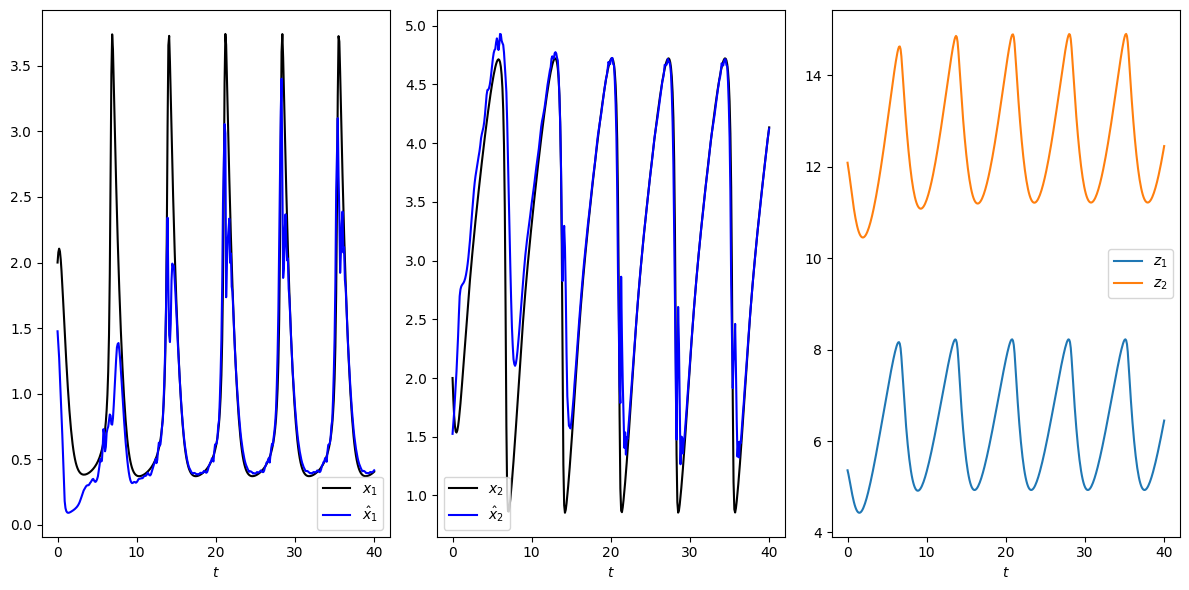

In [5]:
# OBSERVER 

# 1A. PARAMETERS AND FUNCTIONS
A = 1.0
B = 3.0
t_array = np.linspace(0, 40, 401)
x0, xhat0 = np.array([2.0, 2.0]), np.array([1.5, 1.5]) 

gov_eq_brusselator = lambda x: np.array([A + x[0]**2*x[1] - (B)*x[0] - x[0], (B)*x[0] - x[0]**2*x[1]])
h = lambda x: x[1]
Tx = lambda x: brusselator_Tx.Tx(x).real
dTx = lambda x: brusselator_Tx.jacobian(x).real
fobs = lambda z, x: np.array([lambda_values[0]*z[0] + h(x), lambda_values[1]*z[1] + h(x)])
hobs = lambda z: inv_T(z)

# 1B. RUN THE OBSERVER
brusselator_obs = observer(f=gov_eq_brusselator, fobs=fobs, hobs=hobs, Tx=Tx, dTx=dTx, mode='static')
brusselator_obs.simulate((x0, xhat0), t_array)
brusselator_obs.make_xt_plot()

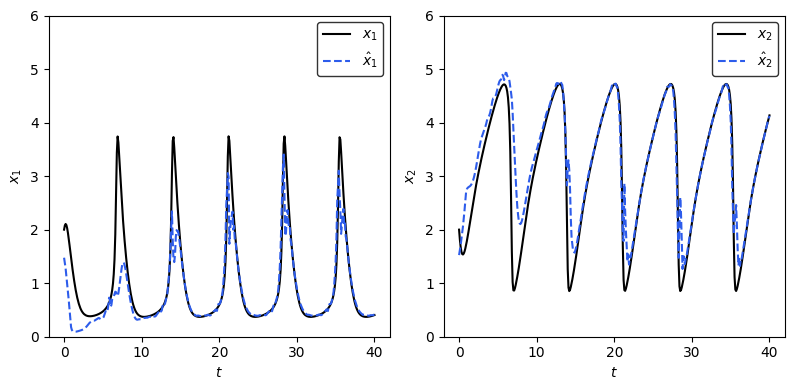

(None, None)

In [6]:
# PLOT SYSTEM STATE TRAJECTORY (FORMATTED FOR PAPER)
plt.style.use('default')
plt.figure(figsize=(12, 4))
for k in range(brusselator_obs.dim):
    plt.subplot(1, brusselator_obs.dim+1, k+1)
    plt.plot(brusselator_obs.t, brusselator_obs.state_sol[:, k], 'k', label=r'$x_{%i}$'%(k+1))
    plt.plot(brusselator_obs.t, brusselator_obs.xhat_sol[:, k], color = "#2D5CEB", linestyle = '--', label=r'$\hat{x}_{%i}$'%(k+1))
    plt.xlabel(r'$t$'), plt.ylabel(r'$x_{%i}$'%(k+1)), plt.legend().get_frame().set_edgecolor('black')
    plt.ylim(0, 6)
plt.tight_layout(), plt.show()

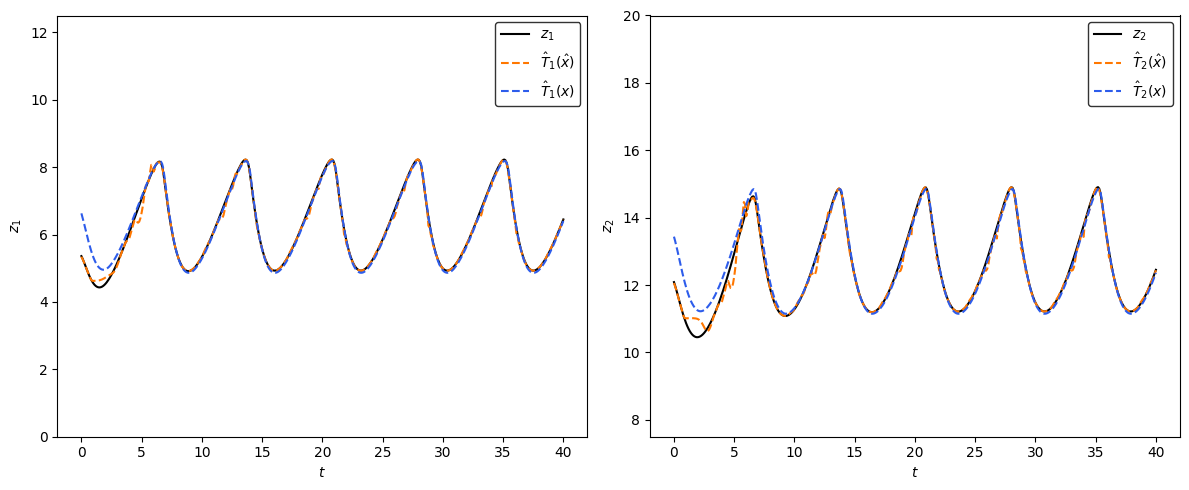

(None, None)

In [7]:
# PLOT OBSERVER STATE TRAJECTORY
z = []
for i in range(brusselator_obs.state_sol.shape[0]):
    z_i = Tx(brusselator_obs.state_sol[i]).real
    z.append((np.array([0., 0.]) if abs(z_i).max() > 30 else z_i)) 
z = np.array(z)
z_hat = []
for i in range(brusselator_obs.state_sol.shape[0]):
    z_hat_i = Tx(brusselator_obs.xhat_sol[i]).real
    z_hat.append((np.array([0., 0.]) if abs(z_hat_i).max() > 30 else z_hat_i))
z_hat = np.array(z_hat)
plt.figure(figsize=(12, 5))
for q in range(2):
    plt.subplot(1, 2, q+1)
    plt.plot(t_array, brusselator_obs.obs_sol[:, q], 'k', label=r'$z_{%d}$' % (q+1))
    plt.plot(t_array, z_hat[:, q], color = "#FF7700", linestyle='--', label=r'$\hat{T}_{%d}(\hat{x})$' % (q+1))
    plt.plot(t_array, z[:, q], color = "#2D5CEB", linestyle = '--', label=r'$\hat{T}_{%d}(x)$' % (q+1))
    plt.xlabel(r'$t$'), plt.ylabel(r'$z_{%d}$' % (q+1)), plt.legend().get_frame().set_edgecolor('black')
    if q == 0:
        plt.ylim(0, 12.5)
    else: 
        plt.ylim(7.5, 20)
plt.tight_layout(), plt.show()

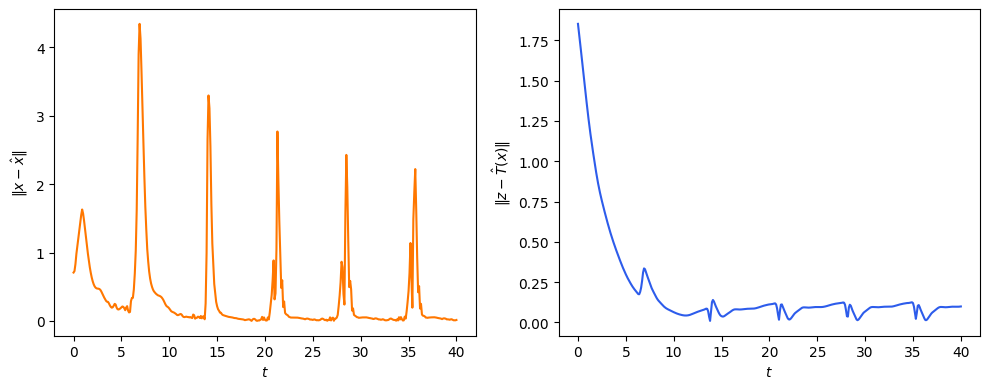

In [8]:
# PLOT ERROR 

# 1A. COMPUTE ERROR
state_error = brusselator_obs.state_sol - brusselator_obs.xhat_sol
state_error_norm = np.linalg.norm(state_error, axis=1)

obs_error = z - brusselator_obs.obs_sol
obs_error_norm = np.linalg.norm(obs_error, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 2A. STATE ERROR PLOT
ax[0].plot(t_array, state_error_norm, color="#FF7700")
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\|x-\hat{x}\|$')

# 2B. OBSERVER ERROR PLOT
ax[1].plot(t_array, obs_error_norm, color="#2D5CEB")
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$\|z-\hat{T}(x)\|$')
plt.tight_layout()
plt.show()
